# HW3- Pytorch

In [12]:
import numpy 
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time 
import matplotlib.pyplot as plt

In [27]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 10
N_CLASSES = 27

### Create Dataset for loading HW3 dataset file

In [9]:
def get_int(b: bytes) -> int:
  '''
  convert bytes to int
  '''
  return int.from_bytes(b, "big")

In [28]:
from torch.utils.data import Dataset

class LettersDataset(Dataset):

  def __init__(self, label_path, image_path):
    
    with open(label_path, 'rb') as f:
      self.label_data = f.read()
      self.label_len = get_int(self.label_data[0:4])

    with open(image_path, 'rb') as f:
      self.image_data = f.read()
      self.image_len = get_int(self.image_data[0:4])
      self.image_col = get_int(self.image_data[4:8])
      self.image_row = get_int(self.image_data[8:12])  
      
    assert self.label_len == self.image_len

  def __len__(self):
    return self.label_len

  def __getitem__(self,idx): 
    label_start_idx = 4 
    label = self.label_data[label_start_idx + idx]

    image_start_idx = 12
    row = self.image_row
    col = self.image_col
    offset = image_start_idx + idx * row * col
    image = numpy.frombuffer(self.image_data, dtype=numpy.uint8, count=col*row, offset=offset).reshape(col,row)
    image = T.ToTensor()(image)

    return image, label

### Mount Google Drive 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Dataset with DataLoader

In [29]:
test_label_path = "/content/drive/My Drive/Colab Notebooks/hw3-letters-test-labels-idx1-ubyte"
test_image_path = "/content/drive/My Drive/Colab Notebooks/hw3-letters-test-images-idx3-ubyte"
test_data = LettersDataset(test_label_path, test_image_path)

training_label_path = "/content/drive/My Drive/Colab Notebooks/hw3-letters-train-labels-idx1-ubyte"
training_image_path = "/content/drive/My Drive/Colab Notebooks/hw3-letters-train-images-idx3-ubyte"
training_data = LettersDataset(training_label_path, training_image_path)

training_loader = DataLoader(dataset=training_data, 
               batch_size=BATCH_SIZE, 
               shuffle=True)

test_loader = DataLoader(dataset=test_data, 
             batch_size=BATCH_SIZE, 
             shuffle=False) 

In [30]:
print(training_data[0][0].shape)
print(training_data[0][0].dtype)

torch.Size([1, 28, 28])
torch.float32


### Plot Letter Dataset

Text(0.5, 0.98, 'Letter Dataset - preview')

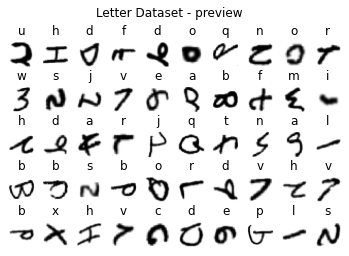

In [31]:
labels_map = {}
for i, c in enumerate("abcdefghijklmnopqrstuvwxyz"):
  labels_map[i+1] = c


fig = plt.figure()
row, col = 5, 10
for index in range(1, row * col + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    image, label = test_data[sample_idx]
    plt.subplot(row, col, index) 
    plt.axis('off')
    plt.title(labels_map[label])
    plt.imshow(image.squeeze(), cmap="gray_r")
fig.suptitle('Letter Dataset - preview')

### Convolutional Neural Network

In [32]:
from torch import nn

class NeuralNetwork(nn.Module):
  def __init__(self, n_classes):
    super(NeuralNetwork, self).__init__()

    self.feature_extractor = nn.Sequential(            
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
        nn.Tanh()
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=n_classes),
    )


  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

### Training and Testing

In [33]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
  running_loss = 0

  for X, y in dataloader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)

    pred, _ = model(X)
    loss = loss_fn(pred, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(dataloader.dataset)
  return epoch_loss
  
def test_loop(dataloader, model, loss_fn, device):
  running_loss = 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      
      pred, _ = model(X)
      loss = loss_fn(pred, y)
      running_loss += loss.item() * X.size(0)
  
  epoch_loss = running_loss / len(dataloader.dataset)

  return epoch_loss

In [34]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [35]:
def train(device, training_loader, test_loader):
  model = NeuralNetwork(N_CLASSES).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  start_time = time.time()

  for i in range(N_EPOCHS):
    train_loss = train_loop(training_loader, model, loss_fn, optimizer, device)
    test_loss = test_loop(test_loader, model, loss_fn, device)
    train_acc = get_accuracy(model, training_loader, device)
    test_acc = get_accuracy(model, test_loader, device)
    
    elapse = time.time() - start_time
    print("Epoch {}".format(i))
    print("Elapse: {:.2f}s".format(elapse))
    print("Train loss: {}".format(train_loss))
    print(f'Train accuracy: {100 * train_acc:.2f}')
    print("Test loss: {}".format(test_loss))
    print(f'Test accuracy: {100 * test_acc:.2f}')
    print("----------------------")
  
    if 100 * test_acc > 90:
      break

  print("Done")
  return model

### Train with CPU

In [36]:
device = "cpu"
model = train(device, training_loader, test_loader)

Epoch 0
Elapse: 67.28s
Train loss: 0.606600420578168
Train accuracy: 89.60
Test loss: 0.3425740741021358
Test accuracy: 89.01
----------------------
Epoch 1
Elapse: 142.08s
Train loss: 0.29460317930063373
Train accuracy: 91.59
Test loss: 0.2848664496581142
Test accuracy: 90.79
----------------------
Done


### Train with GPU

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = train(device, training_loader, test_loader)

Using cpu device
Epoch 0
Elapse: 67.26s
Train loss: 0.608150003100626
Train accuracy: 90.10
Test loss: 0.340330215569299
Test accuracy: 89.35
----------------------
Epoch 1
Elapse: 134.78s
Train loss: 0.2961155983996697
Train accuracy: 91.56
Test loss: 0.2943090664043736
Test accuracy: 90.53
----------------------
Done


### Confusion Matrix

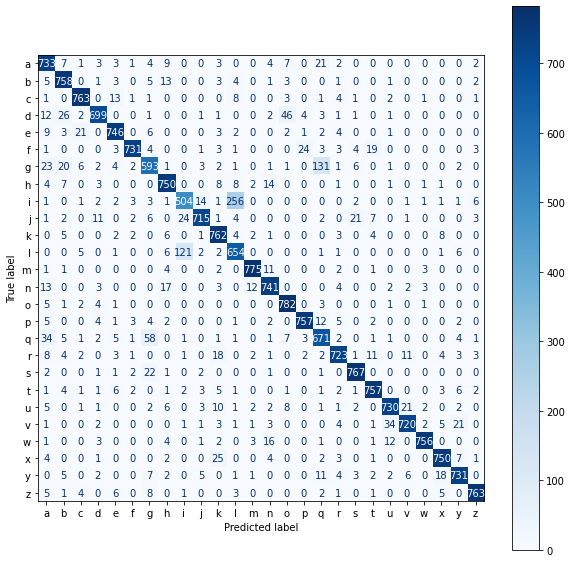

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

display_labels = numpy.array([i for i in range(1,28)])
display_labels = numpy.array([ch for ch in "abcdefghijklmnopqrstuvwxyz"])

all_trues = torch.tensor([]).to(device)
all_preds = torch.tensor([]).to(device)

with torch.no_grad():
  i = 0
  for X, y_true in test_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    _, y_prob = model(X)
    _, predicted_labels = torch.max(y_prob, 1)
    
    all_trues = torch.cat((all_trues, y_true), dim=0)
    all_preds = torch.cat((all_preds, predicted_labels))

    i += 1

fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(all_trues.cpu(), all_preds.cpu())
disp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()